# Explainability for Random Forest Model

## Setup

Importing all required packages and define seed and number of cores to use.

In [1]:
import os
import pandas as pd
import numpy as np
import sys
import pickle

sys.path.append('./')
import utils

from collections import Counter
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, r2_score
from scipy.stats import spearmanr

import shap
from fgclustering import FgClustering

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(os.cpu_count()) # how many CPU cores are available on the current machine

8


In [3]:
seed = 42
n_jobs = 4

## Load the Model

In [4]:
case = 3
undersample = True
model_type = "reg"

Loaded the following model: RandomForestRegressor(criterion='poisson', max_depth=50, max_features='sqrt',
                      max_samples=0.8, n_estimators=1000, oob_score=True,
                      random_state=42)
Train set MSE: 0.001
Train set R^2: 0.993
Train set Spearman R: 0.995


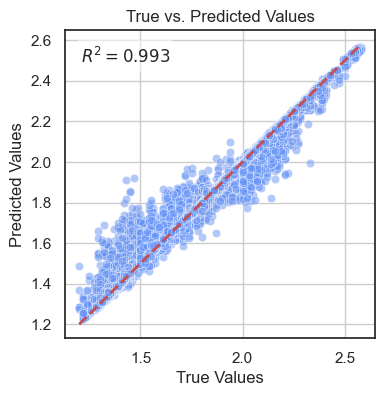

Test set MSE: 0.057
Test set R^2: -0.891
Test set Spearman R: 0.14


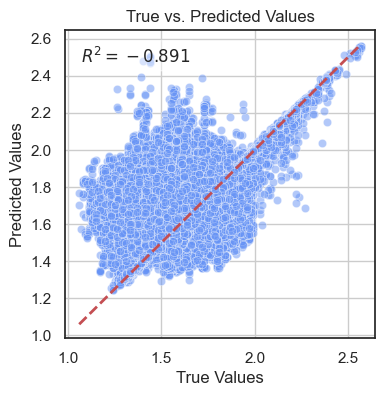

In [6]:
if model_type == "class":

    # Load and unpack the data
    with open(f'../models/{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}.pickle', 'rb') as handle:
        data_and_model = pickle.load(handle)

    X_train, X_test, y_train, y_test, model = data_and_model

    print(f'Loaded the following model: {model}')

    print('Training dataset target distribution:')
    print(Counter(y_train))

    print('Test dataset target distribution:')
    print(Counter(y_test))

    # is the model performing reasonably on the training data?
    print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, model.predict(X_train))*100,2)} % balanced accuracy.')

    # is the model performing reasonably on the test data?
    print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, model.predict(X_test))*100,2)} % balanced accuracy.')

if model_type == "reg":
    # Load and unpack the data
    with open(f'../models/{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}.pickle', 'rb') as handle:
        data_and_model = pickle.load(handle)

    data_train, data_test, model = data_and_model

    y_train = data_train['AI_10min']
    y_train_cat = data_train['AI_10min_cat']
    X_train = data_train.drop(columns=['AI_10min', 'AI_10min_cat'])
    y_test = data_test['AI_10min']
    X_test = data_test.drop(columns=['AI_10min', 'AI_10min_cat'])

    print(f'Loaded the following model: {model}')

    # Predict labels
    y_pred = model.predict(X_train)
    y_true = y_train

    print(f"Train set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
    print(f"Train set R^2: {round(r2_score(y_true, y_pred), 3)}")
    print(f"Train set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

    utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

    # Predict labels
    y_pred = model.predict(X_test)
    y_true = y_test

    print(f"Test set MSE: {round(mean_squared_error(y_true, y_pred), 3)}")
    print(f"Test set R^2: {round(r2_score(y_true, y_pred), 3)}")
    print(f"Test set Spearman R: {round(spearmanr(y_true, y_pred).correlation, 3)}")

    utils.plot_predictions(y_true=y_true, y_pred=y_pred, textstr = f'$R^2={round(r2_score(y_true, y_pred), 3)}$')

## Random Forest Feature Importance

The simplest way to explain a Random Forest model is the Random Forest specific feature importance method based on the mean decrease in impurity. The mean decrease in impurity is defined as the total decrease in node impurity averaged over all trees of the ensemble. This Feature Importances is directly provided by the fitted attribute feature_importances_ .

Lets plot the feature importance based on mean decrease in impurity:

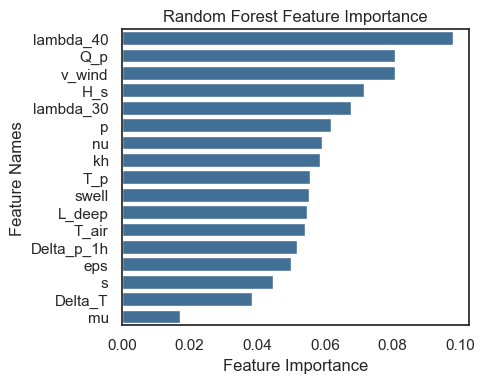

In [7]:
file_plot = f'../results/RFI_{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}.png'
utils.plot_impurity_feature_importance(model.feature_importances_, names=X_train.columns, title="Random Forest Feature Importance", save=file_plot)

## Interpretation with Forest-Guided Clustering

In [8]:
data_fgc = X_train.copy()
data_fgc["target"] = y_train
#data_fgc["target"] = data_fgc["target"].map({1: 'RogueWave', 0: 'NonRogueWave'})

**Run FGC with subsampling**

In [ ]:
number_of_iterations = 30   # Number of times dataset will be subsampled
sample_size = 5000           # Number of samples in the subsampled dataset
max_K = 10                   # Maximum K for the FGC

k_result =  dict((i,0) for i in range(1, max_K)) # Dictionary to store the result

for i in range(number_of_iterations):
    print(f"Iteration: {i+1}")
    # sample the dataset
    data_sample = data_fgc.sample(
        n = sample_size, replace = False, random_state = i
        ) # setting random state for reproducibility
    # instantiate the fgc object on the subsampled dataset and run it:
    fgc = FgClustering(model=model, data=data_sample, target_column='target')
    fgc.run(max_K = max_K,
            method_clustering = 'pam', 
            discart_value_JI = 0.60, 
            bootstraps_JI = 100, 
            n_jobs = n_jobs, 
            verbose = 0,
            )
    # save the result
    k_result[fgc.k] += 1

In [ ]:
print('Results of k estimation:')
pd.DataFrame(k_result.items(), columns=['k','count']).sort_values(by='count', ascending=False).reset_index(drop=True)

Choose optimal number of clusters k from subsampling optimization and recalculate the clustering for the entire dataset.

Interpreting RandomForestRegressor
Use 2 as number of cluster


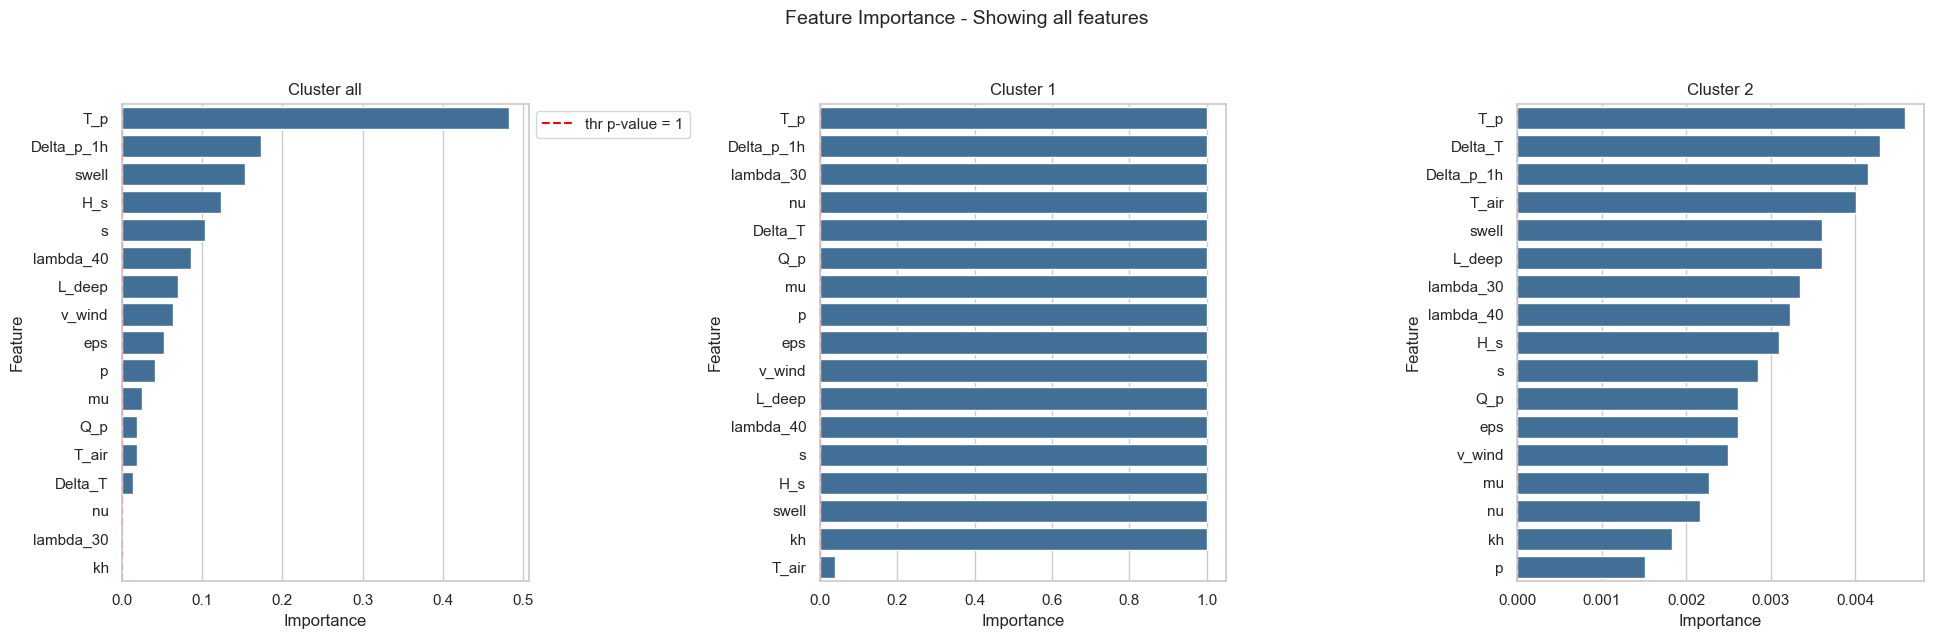

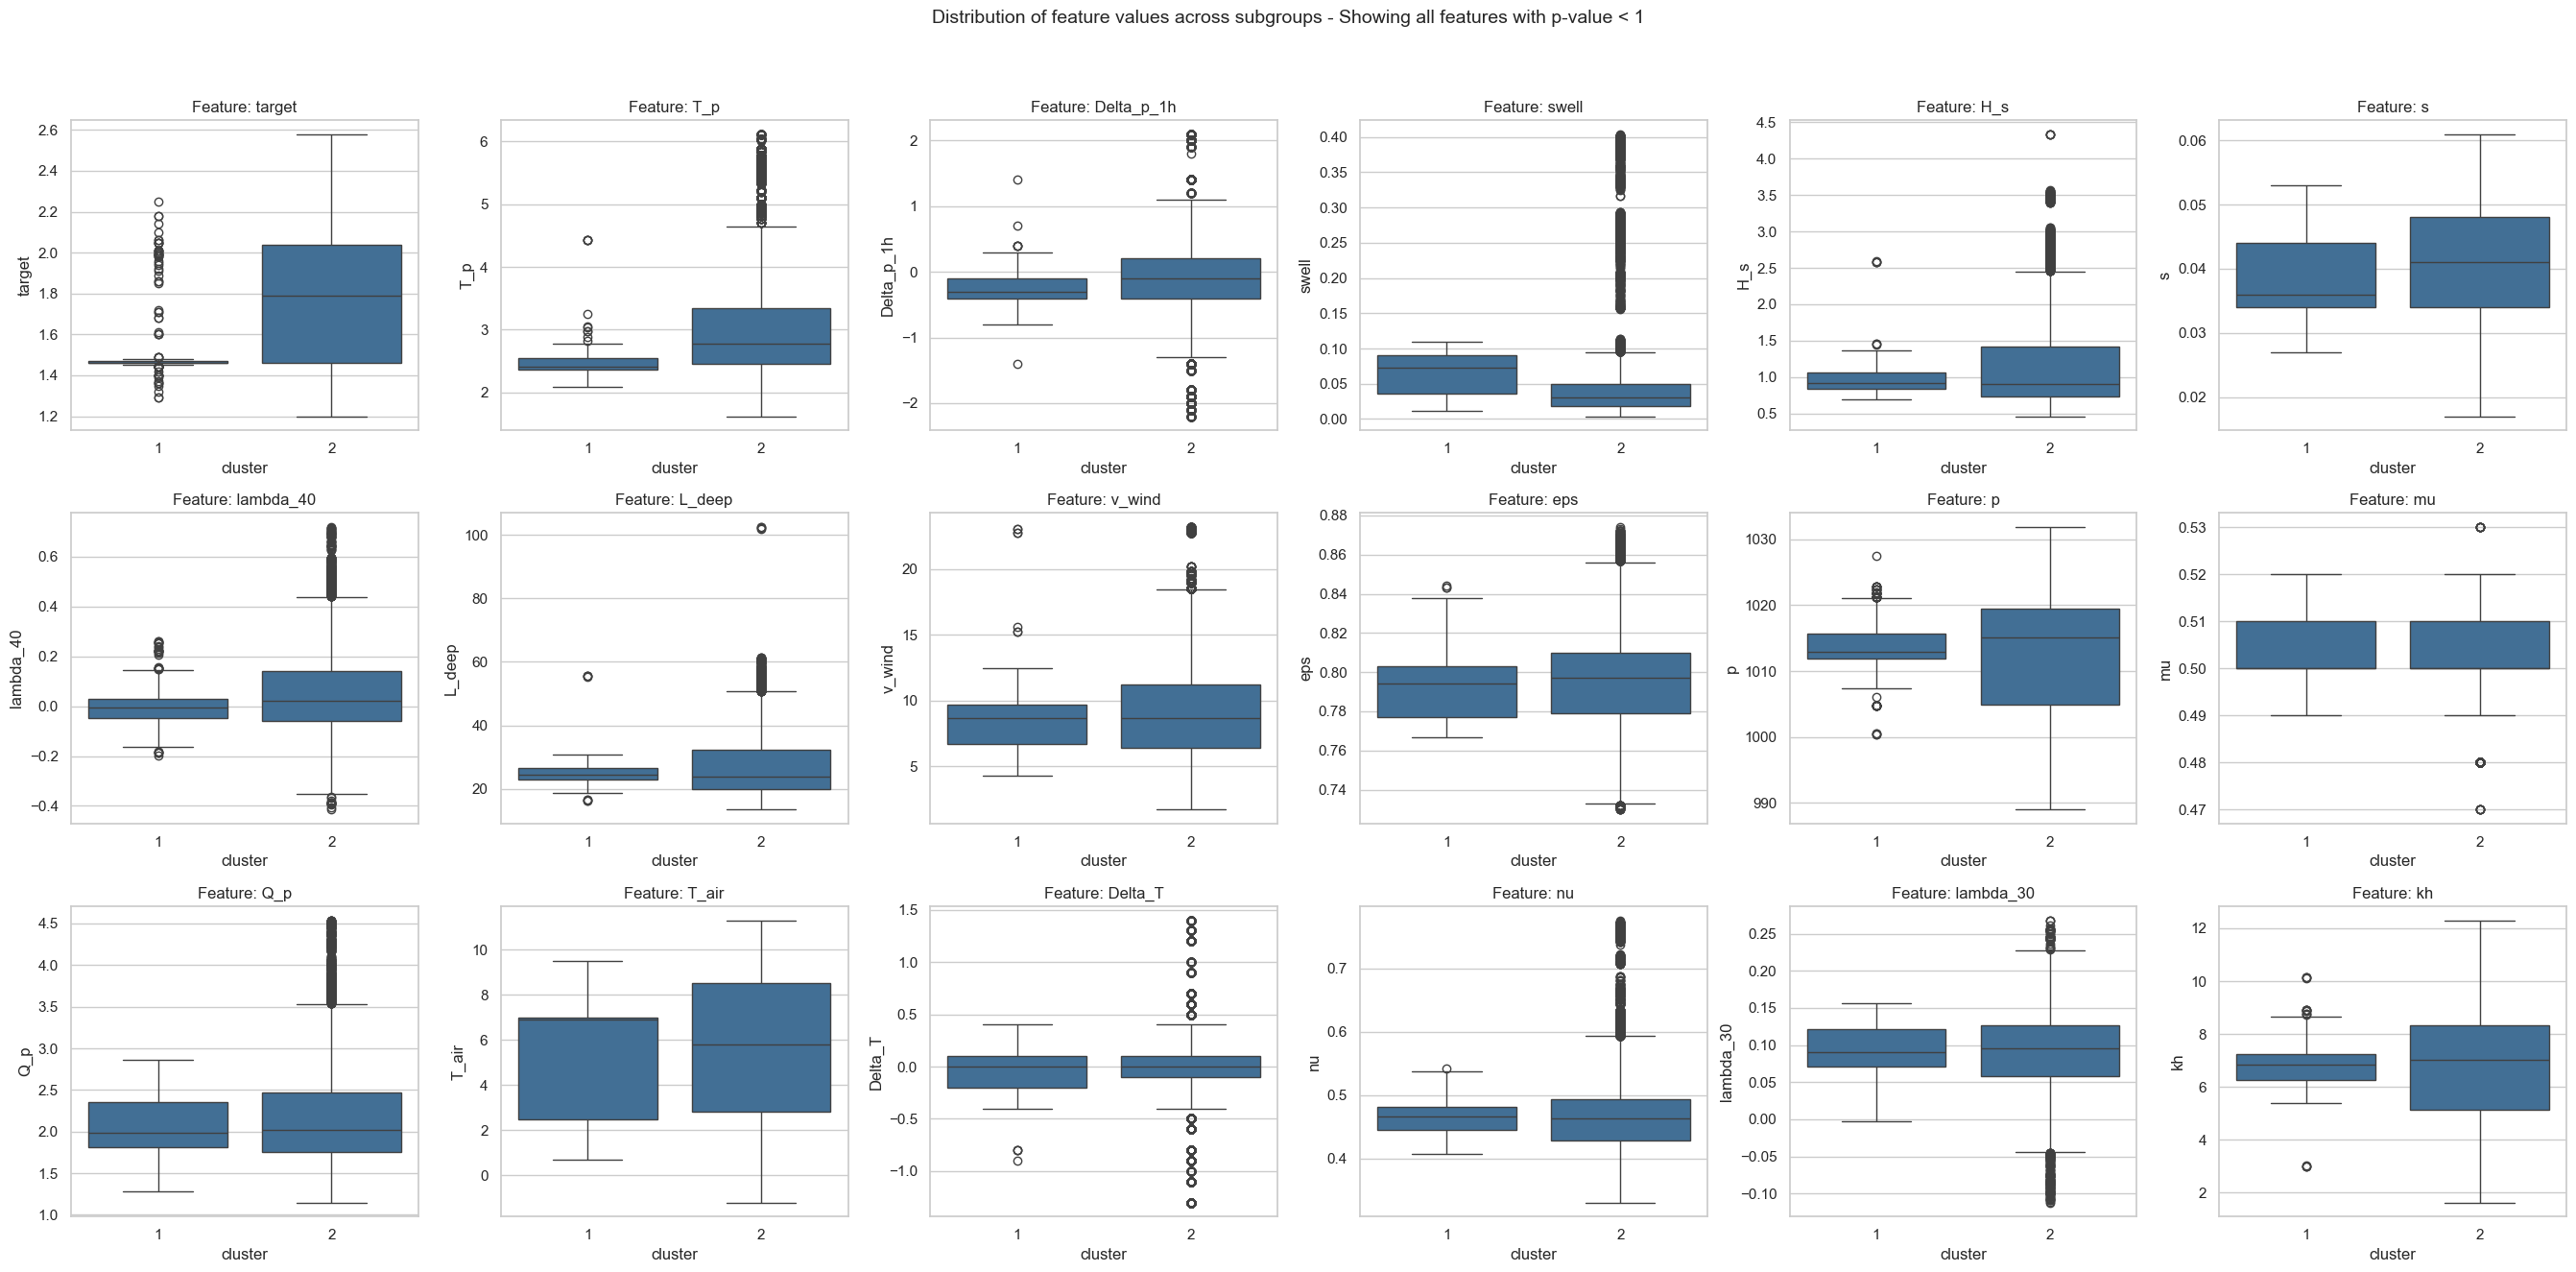

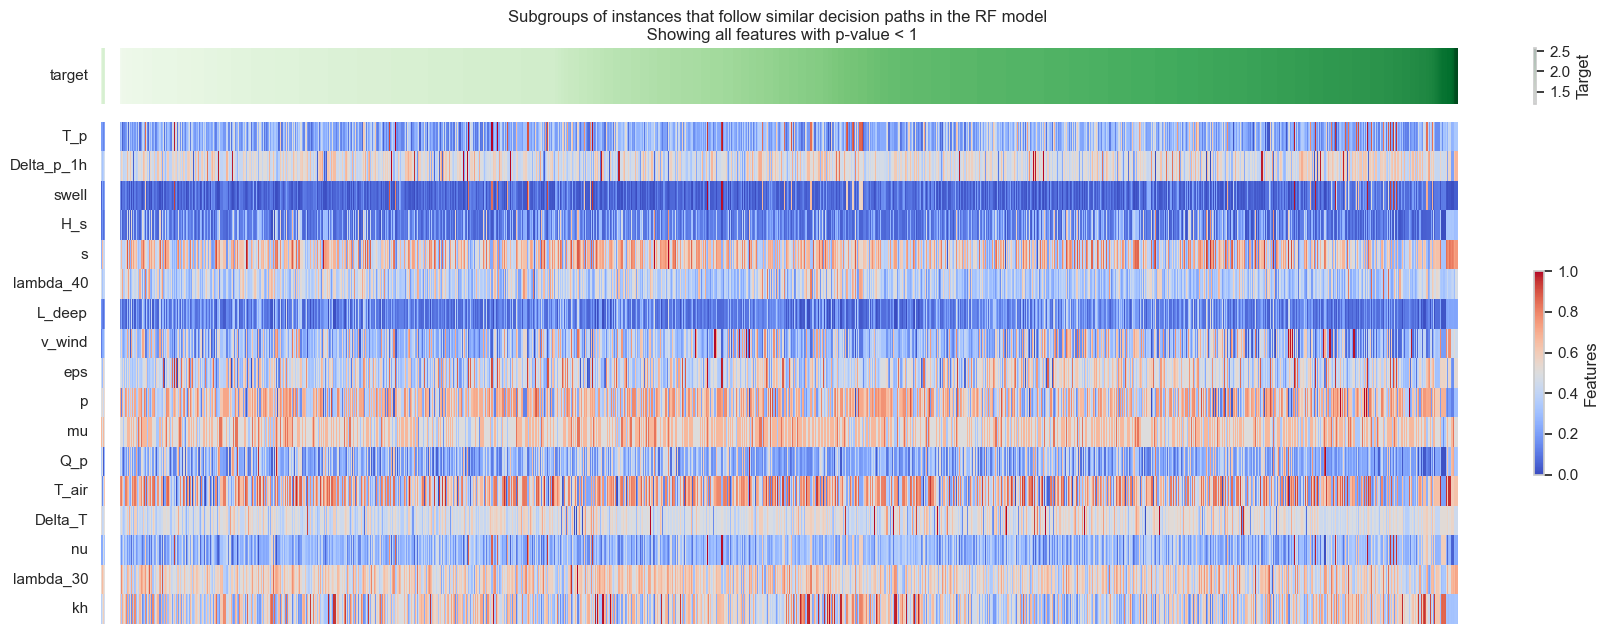

Use 5 as number of cluster


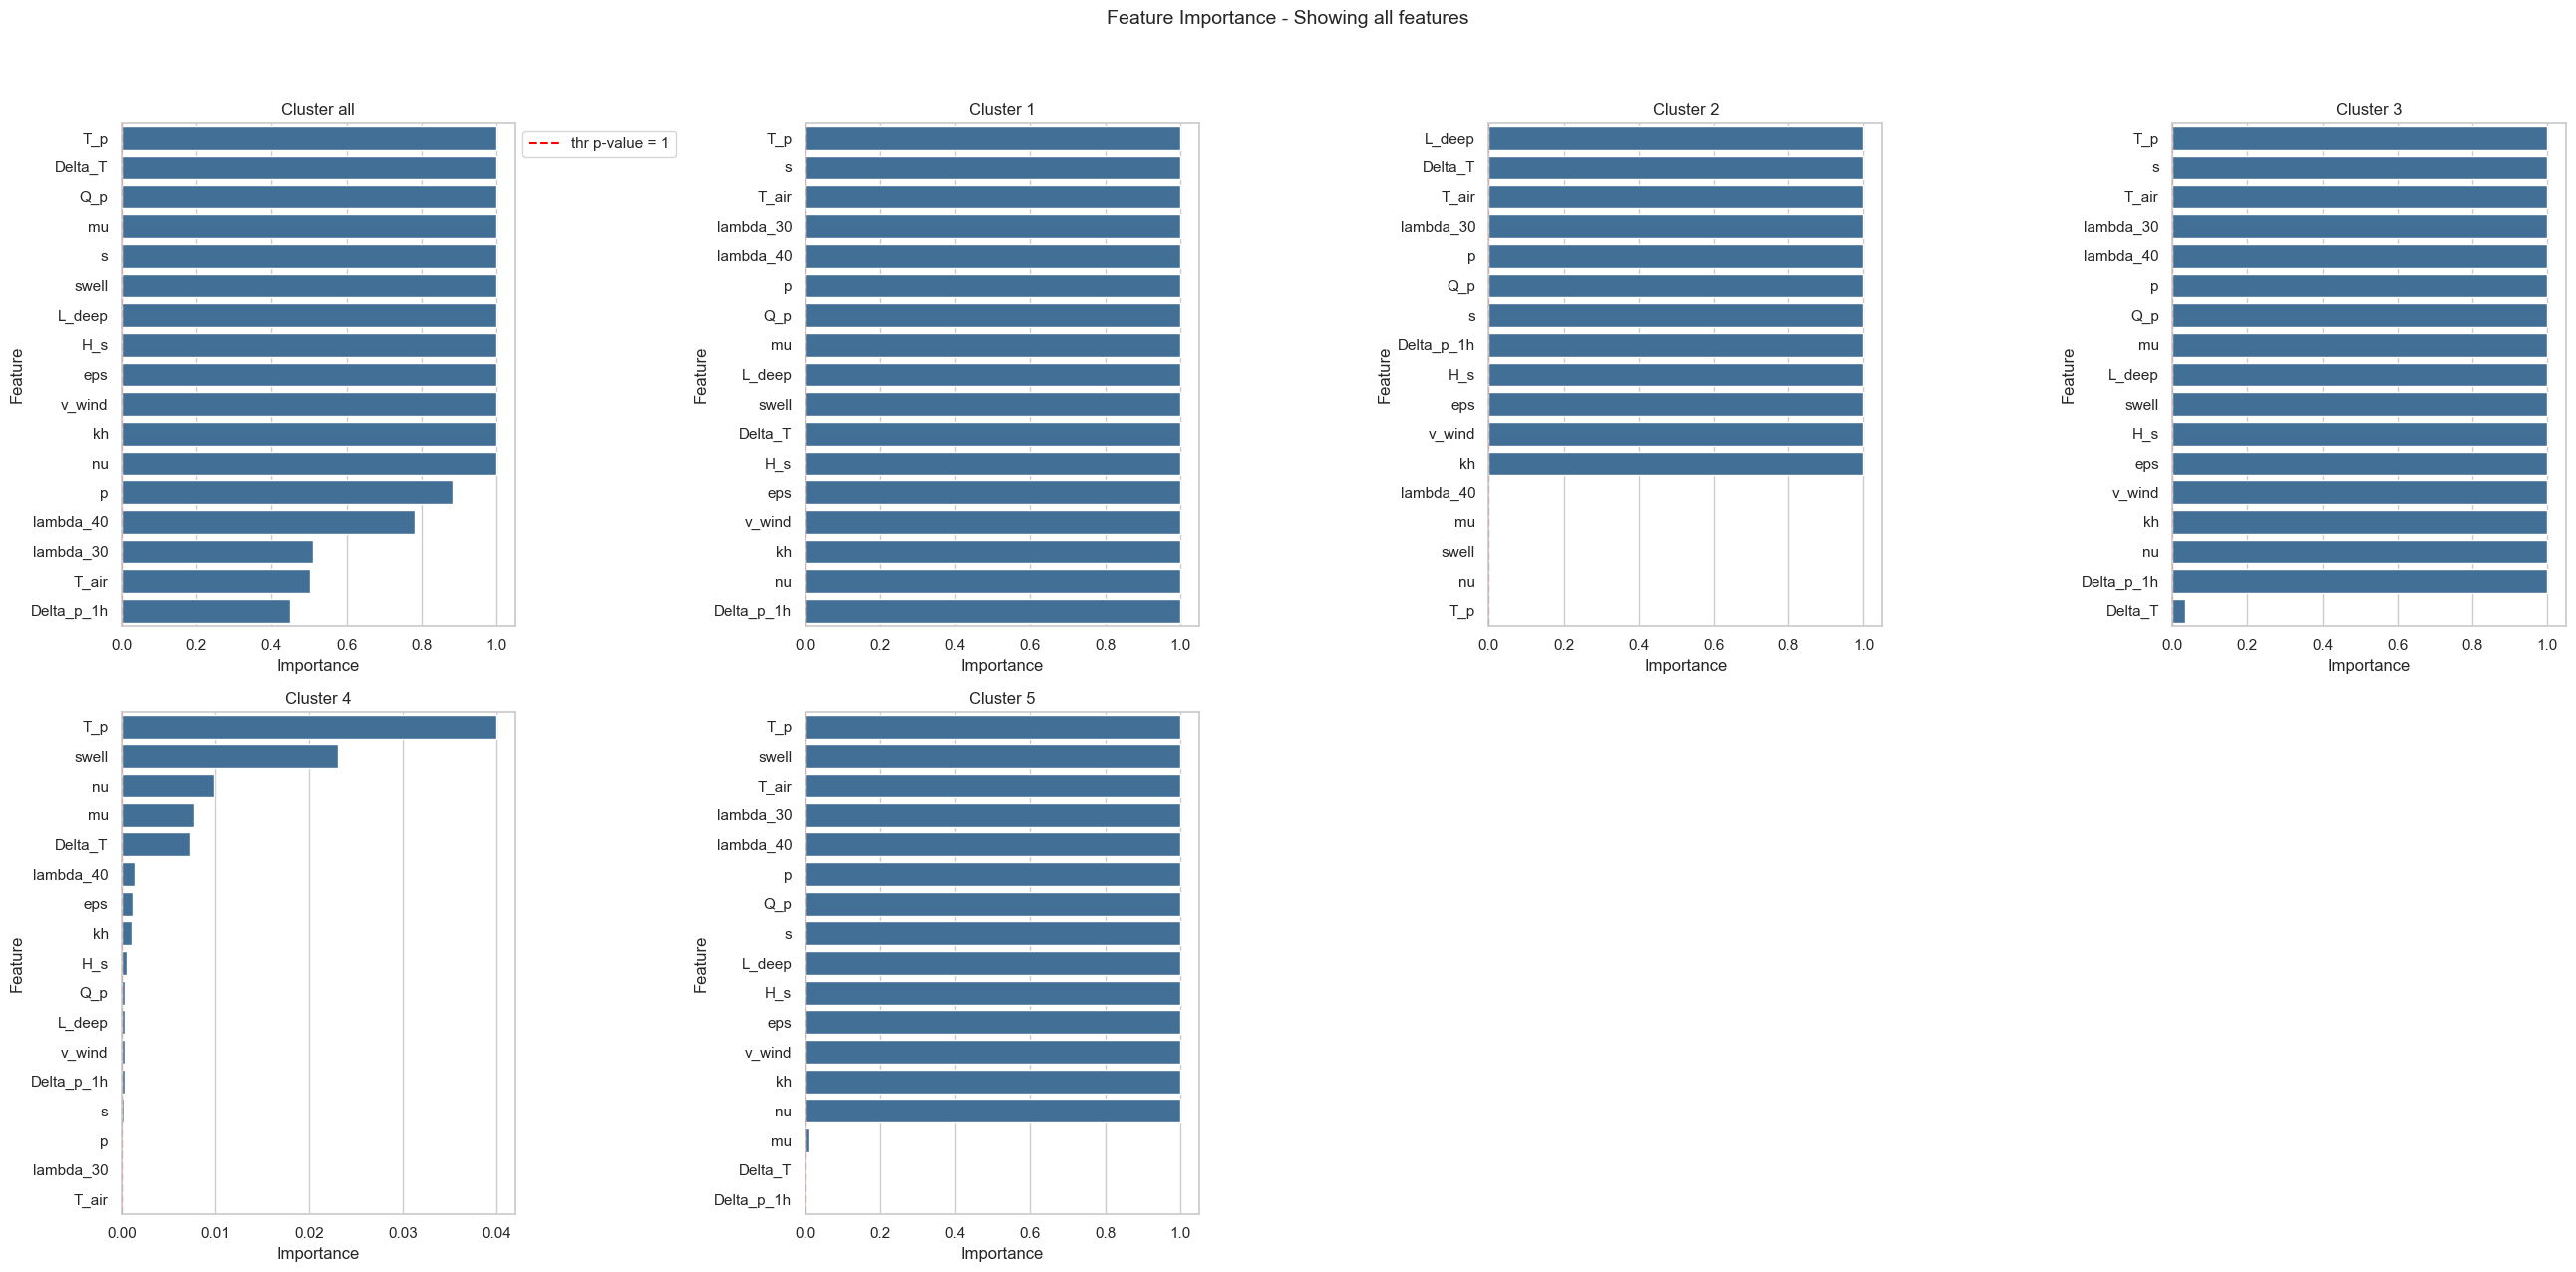

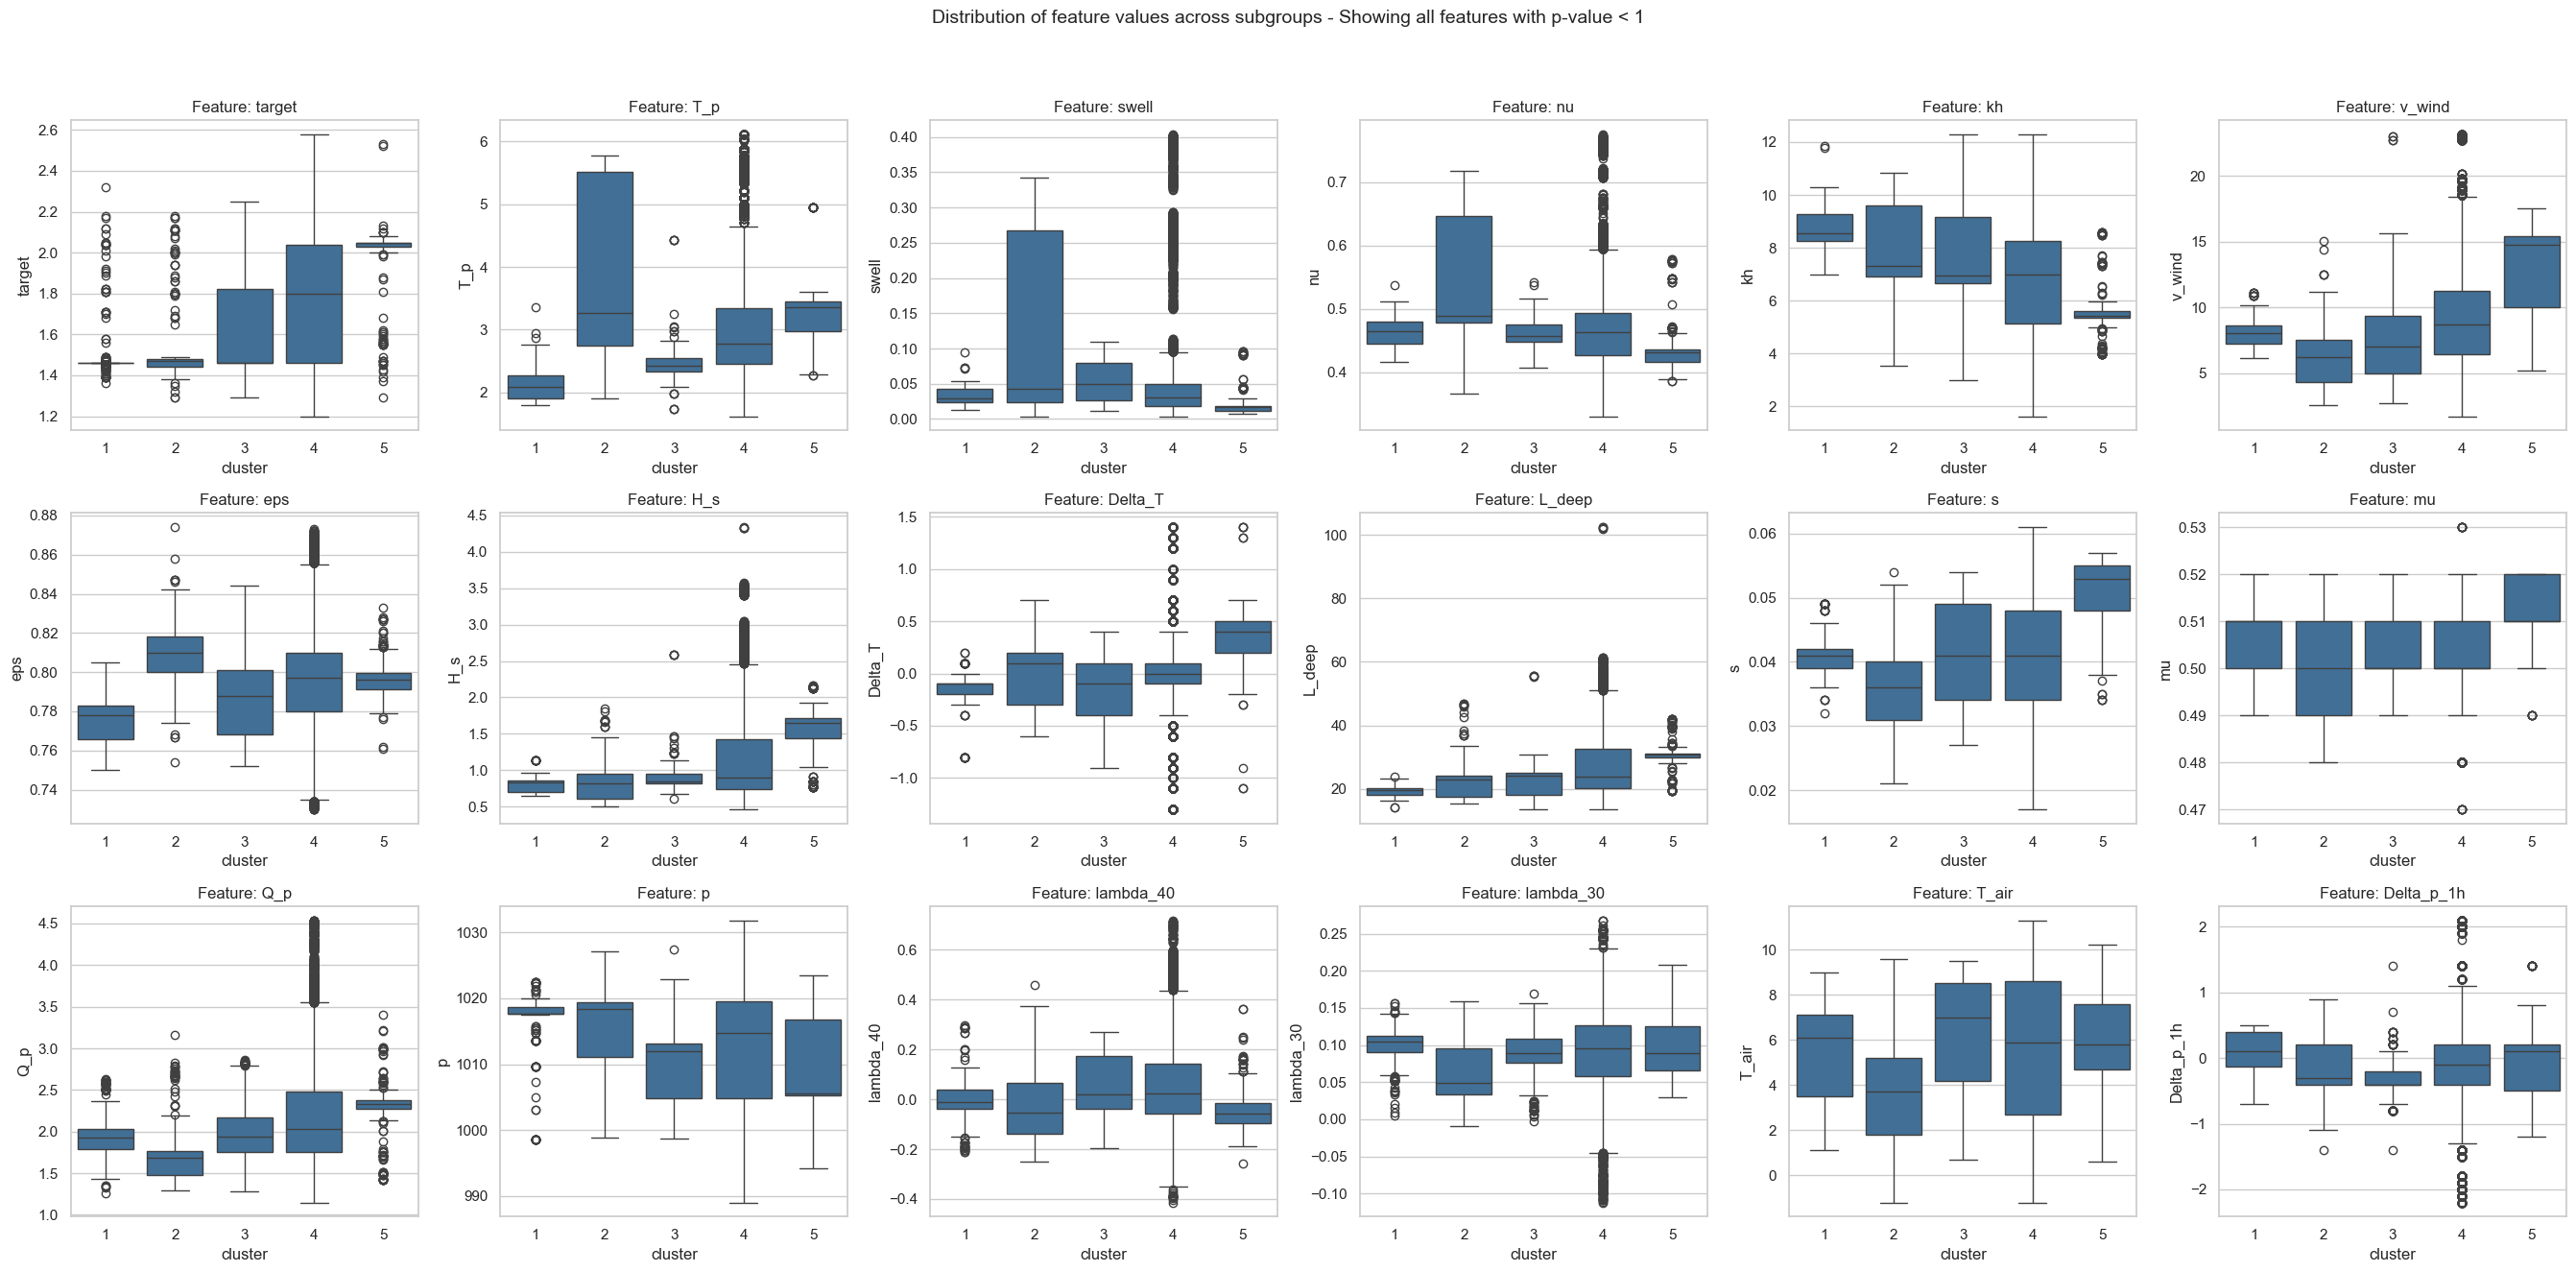

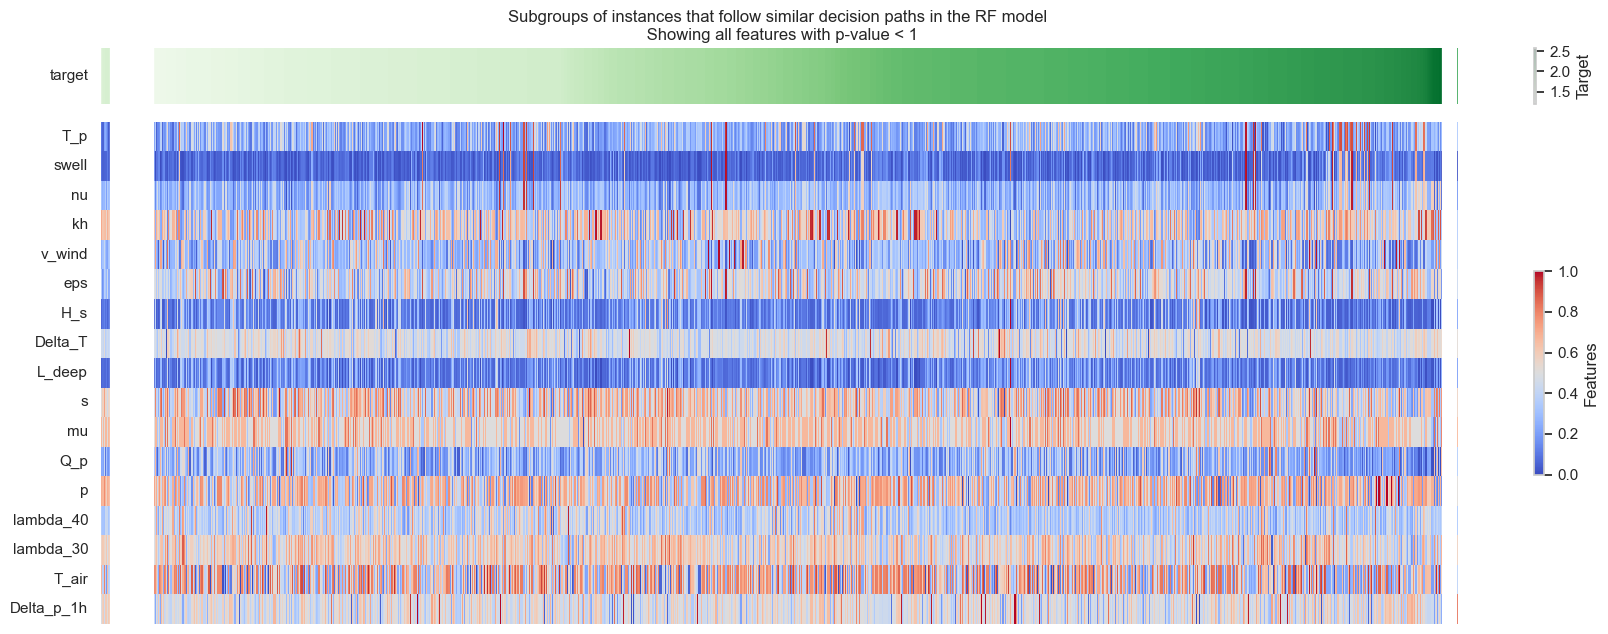

Use 9 as number of cluster


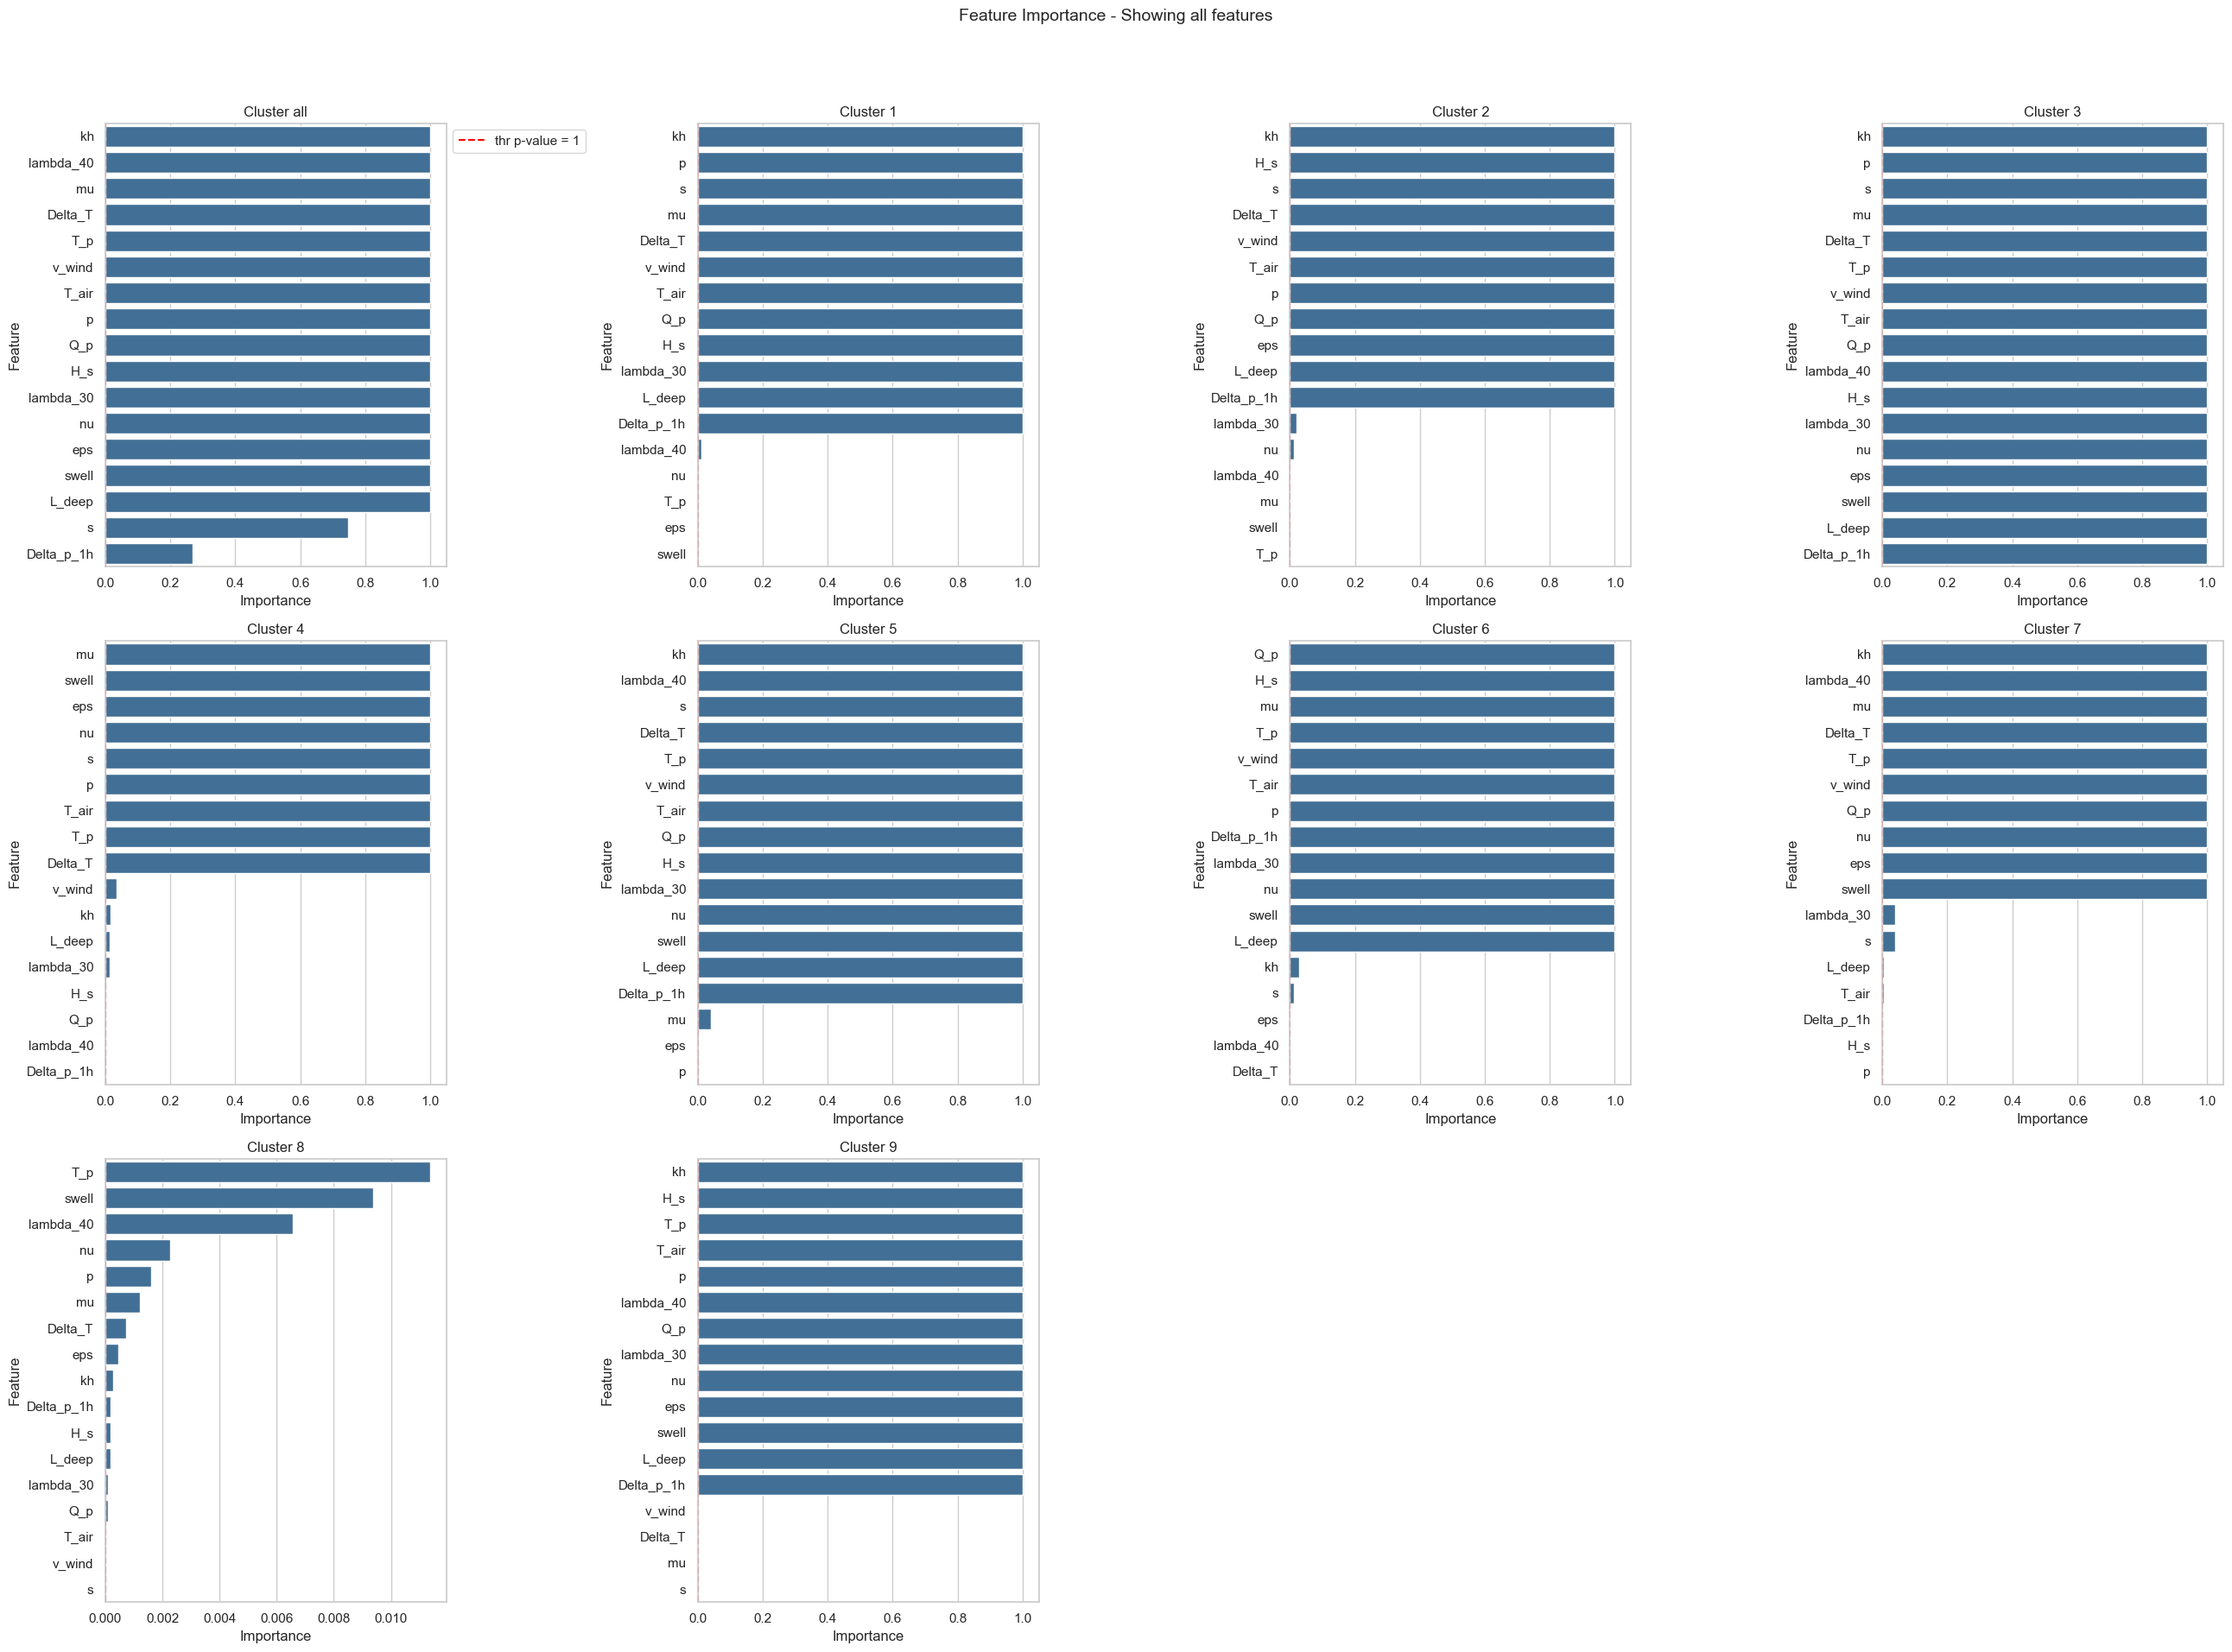

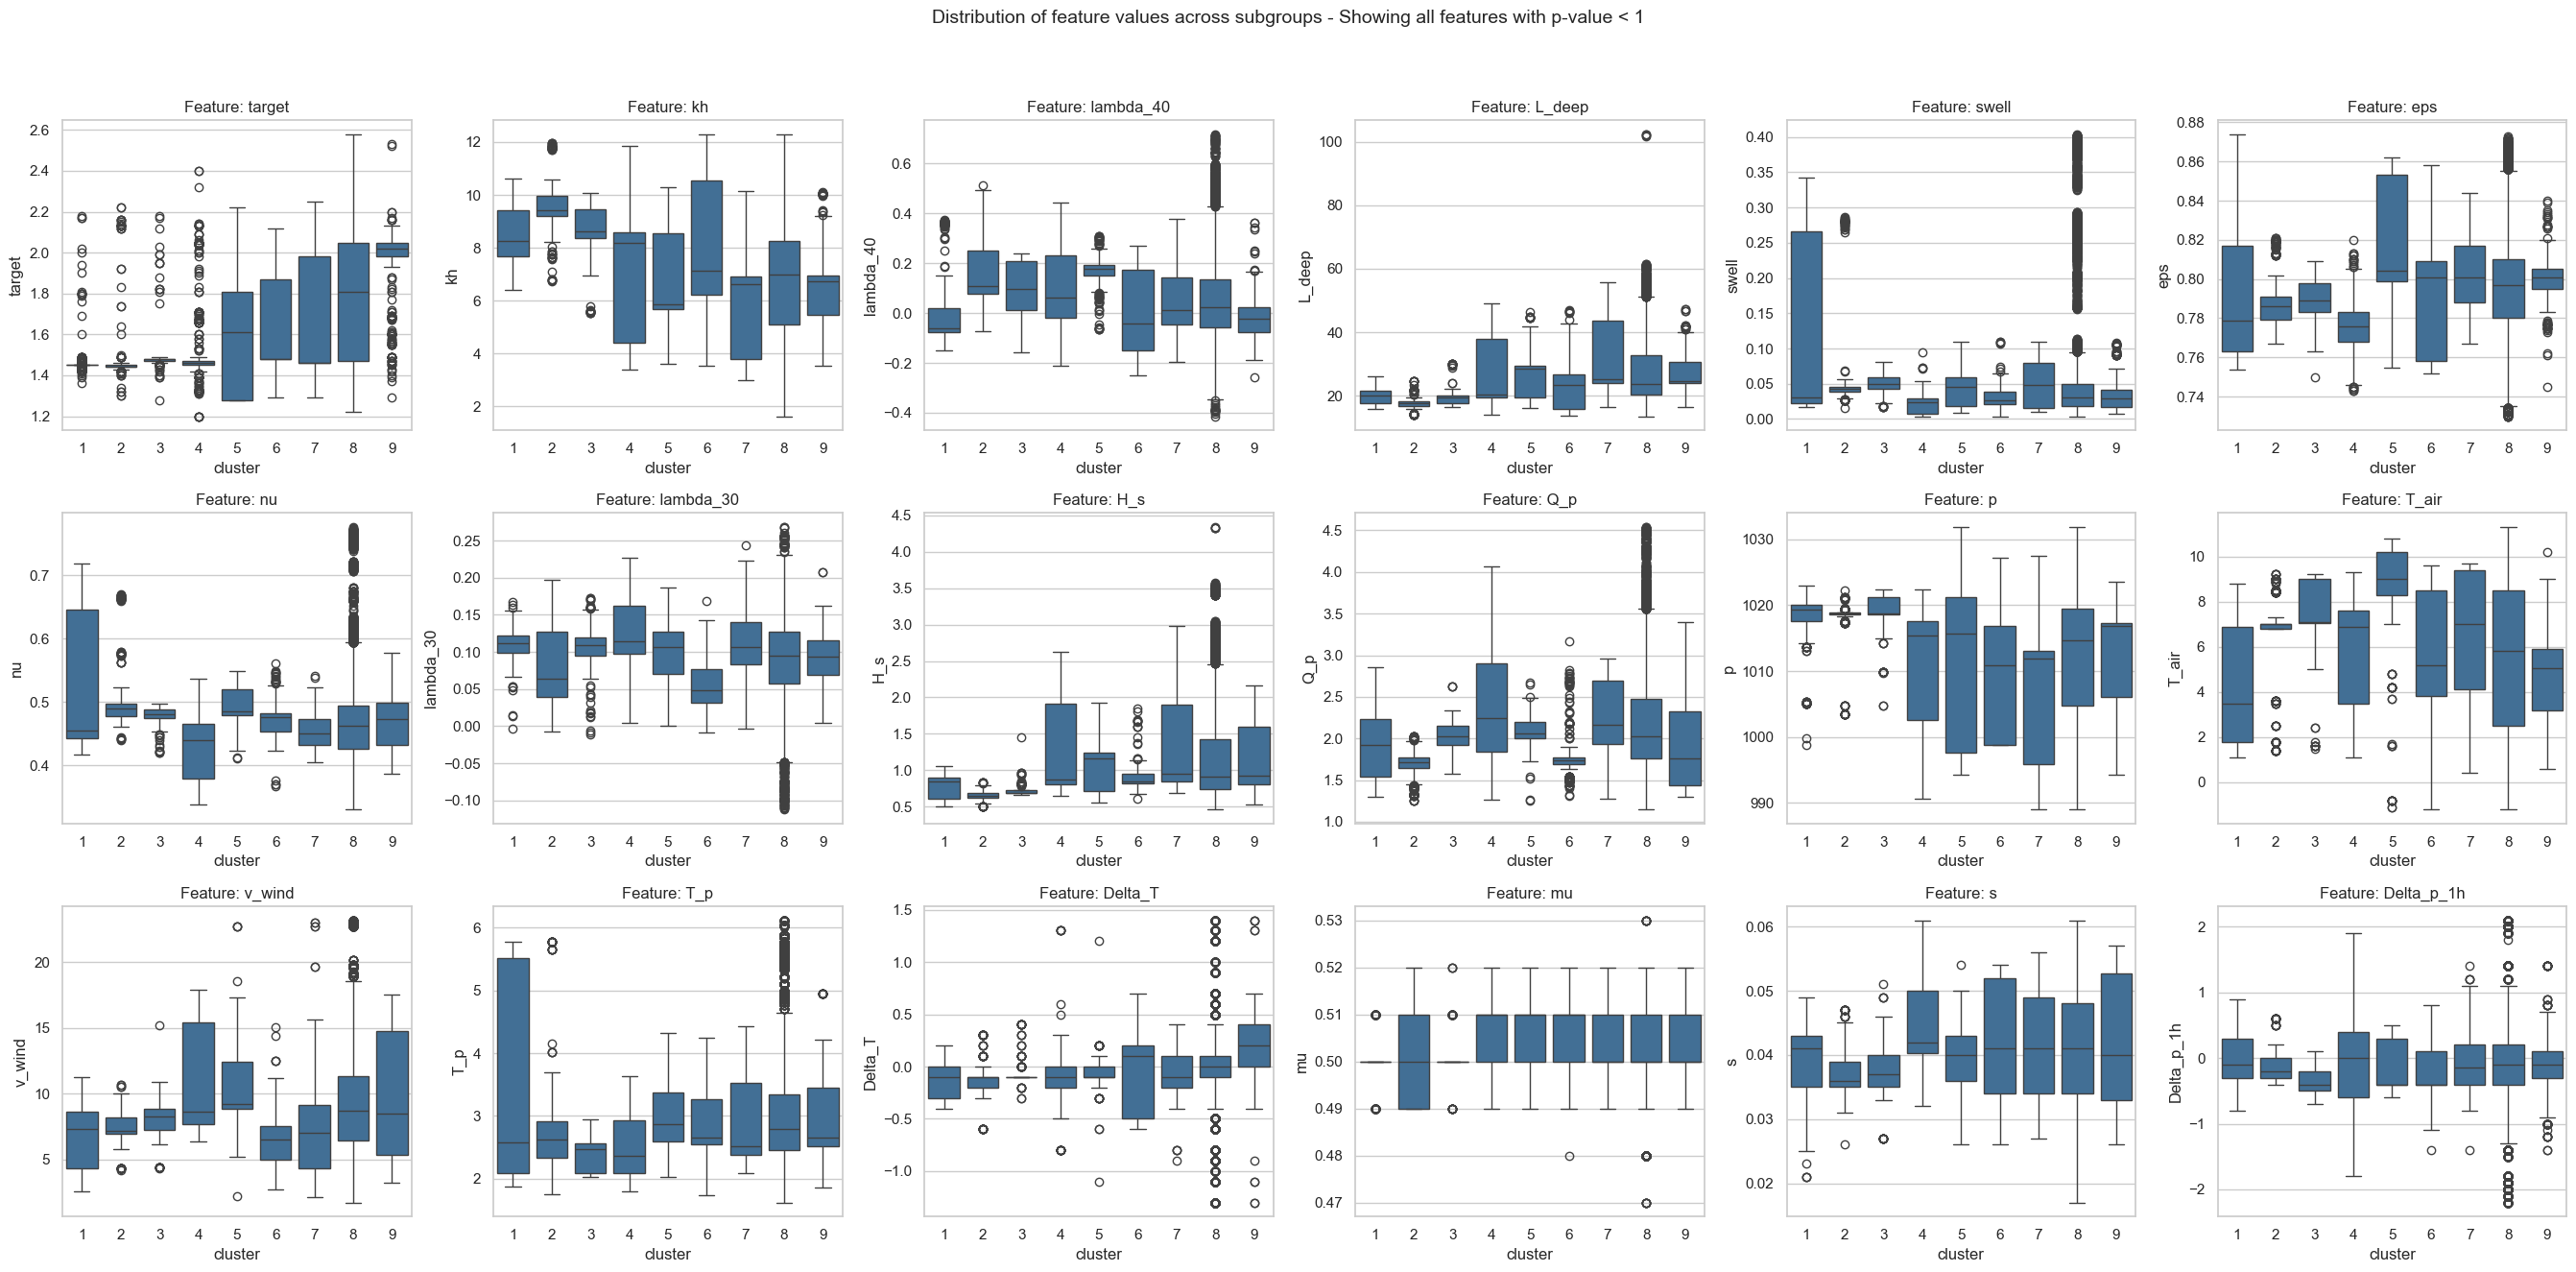

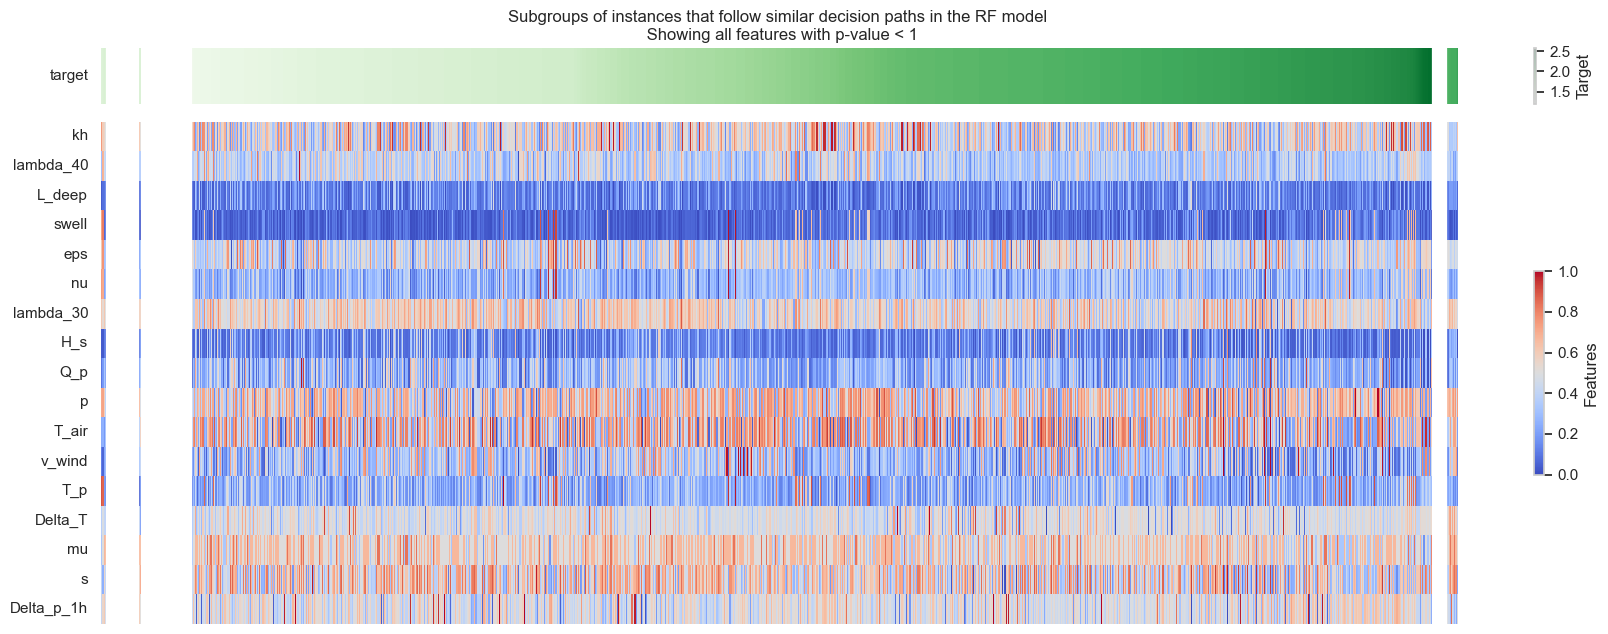

In [9]:
ks = [2,5,9]

fgc = FgClustering(model=model, data=data_fgc, target_column="target")

for k in ks:
        fgc.run(k = k, 
                method_clustering = 'pam', 
                bootstraps_p_value = 100, 
                n_jobs = n_jobs, 
                verbose = 2
        )

        filename = f'../results/FGC_k{k}_{model_type}_model_randomforest_case{case}{"_undersampled" if undersample else ""}_test'

        fgc.plot_feature_importance(save=filename)
        fgc.plot_decision_paths(save=filename)

In [11]:
from collections import Counter

fgc.cluster_labels
print(Counter(fgc.cluster_labels))

Counter({np.uint64(1): 32760, np.uint64(8): 502, np.uint64(7): 442, np.uint64(6): 364, np.uint64(2): 303, np.uint64(3): 295, np.uint64(5): 285, np.uint64(0): 266, np.uint64(4): 207})


## Interpretation with SHAP

With SHAP we get contrastive explanations that compare the prediction with the average prediction. The global interpretations are consistent with the local explanations, since the Shapley values are the “atomic unit” of the global interpretations.

When using TreeExplainer for a Ranfom Forest model, there will be small variations between the average model prediction and the expected value from SHAP. This behaviour is explained as follows in this GitHub thread:

> It is because of how sklearn records the training samples in the tree models it builds. Random forests use a random subsample of the data to train each tree, and it is that random subsample that is used in sklearn to record the leaf sample weights in the model. Since TreeExplainer uses the recorded leaf sample weights to represent the training dataset, it will depend on the random sampling used during training. This will cause small variations like the ones you are seeing.

To get the exact same values, we provide a background dataset for integrating out features. This dataset has to be passed to an Independent masker, which correctly subsamles the data (otherwise only the first 100 samples are subsampled and the expected value might show high variations).

In addition, when using SHAP to explain a classifiers output, the default value in TreeExplainer for model_output="raw", which explains the raw output of the model. For regression models, "raw" is the standard output. For classification this is the log odds ratio. We can set the model_output="probability" explaining the output of the model transformed into probability space, i.e. SHAP values now sum to the probability output of the model.


In [ ]:
# run SHAP
explainer = shap.TreeExplainer(model=model, data=shap.maskers.Independent(X_train, max_samples=100), model_output="probability")
shap_values = explainer(X_train)

# get original unscaled feature values
shap_values.data = X_train.round(4)

#NOTE: the new SHAP package is still a bit buggy.
#      the returned dimensions for the shaply value
#      matrix are swapped. Hence, we need to put
#      then into correct order first.
shap_values.values = list(np.transpose(shap_values.values,(2,0,1)))

In [ ]:
shap.summary_plot(
    shap_values.values, 
    shap_values.data, 
    plot_type='bar')